**Программирование и анализ**

Задание №1  
Поиск 5ти пользователей, сгенерировавших наибольшее количество запросов

Для начала подготовим данные в удобном виде: распарсим лог и сделаем список словарей, где словарь - строчка из лога

In [1]:
import csv
index = 0

file_name = 'access.log'
log = list()
with open(file_name, 'r') as log_file:
    reader=csv.reader(log_file,delimiter=' ')
    for row in reader:
        index += 1
        log.append(filter(None, row))

In [2]:
keys = [key for key in log[0][0].split('\t') if not (key == '' or key == '\n')]
full_log = list()
for row in log:
    temp_dict = dict()
    for i, note in enumerate(row):
        temp_dict[keys[i]] = note
    full_log.append(temp_dict)

Отсортируем наш список по полю username, чтобы можно было бы сгруппировать по этому полю. Для каждого пользователя считаем, сколько запросов он сделал и добавляем это значение в словарь count_request = {username: count}

In [211]:
sorted_log = sorted(full_log[1:], key=lambda x: x['username'])

In [212]:
from itertools import groupby
count_request = dict()
for username, data in groupby(sorted_log, lambda x: x['username']):
    count_request[username] = len(list(data))

In [213]:
import operator
result_request = sorted(count_request.items(), key=operator.itemgetter(1))
result_request[-6:]

[('adda', 2282),
 ('kostenkovag', 2346),
 ('podkopaevata', 2401),
 ('sevankoav', 2707),
 ('anagafonova', 5005),
 ('-', 22559)]

Задание №2  
Поиск 5ти пользователей, отправивших наибольшее количество данных 

Возьмем тот же сортированный список, снова сгруппируем его по полю username и просуммируем поле 'total_request_size' для каждого запроса пользователя. Добавим все в словарь count_size = {username: size}

In [214]:
count_size = dict()
for username, data in groupby(sorted_log, lambda x: x['username']):
    size = sum([int(request['total_request_size']) for request in data])
    count_size[username] = size

In [215]:
result_size = sorted(count_size.items(), key=operator.itemgetter(1))
result_size[-6:]

[('podkopaevata', 80460500),
 ('klo', 81220767),
 ('-', 92142665),
 ('kostenkovag', 99511049),
 ('romangr', 126630571),
 ('valievrs', 173720675)]

Задание №3  
Поиск обращений к зараженным сайтам из списка (http://www.malwaredomainlist.com/hostslist/hosts.txt)

Скачаем файл hosts.txt и распарсим его и положим в список domain_list. 

In [216]:
file_name = 'hosts.txt'
hosts = list()
with open(file_name, 'r') as host_file:
    for row in host_file:
        hosts.append(row.replace('\r\n', ''))
domain_list = [row.split('  ')[1] for row in hosts[6:]]

Для каждого запроса из лога проверяем вхождение в список зараженных сайтов. Обрабатываем формат урлов, которых не смог распарсить urlparse.netloc. На весь лог нашлось только 1 совпадение.

In [217]:
from urlparse import urlparse
counter = 0
bad_requests = list()
for request in full_log[1:]:
    if urlparse(request['request_url']).netloc == '':
        url = ('.'.join(request['request_url'].split('.')[-2:])).split(':')[0]
        if url in domain_list:
            bad_requests.append(request)
    elif urlparse(request['request_url']).netloc in domain_list:
        bad_requests.append(request)
bad_requests

[{'answer_size': '499',
  'hierarhy/server_ip': 'DIRECT/yougube.com',
  'mime_type': '-',
  'referer': 'http://pdf1.alldatasheet.com/datasheet-pdf/view/32435/TOSHIBA/TLP521-1.html',
  'request_method': 'GET',
  'request_status/answer_status': 'TCP_MISS/304',
  'request_url': 'http://yougube.com/bebeok/img/en.gif',
  'response_time': '709',
  'src_ip': '10.226.116.96',
  'time': '1457684277.218',
  'total_request_size': '283',
  'username': 'brychkinnb'}]

Задание №4  
Поиск регулярных запросов (запросов выполняющихся периодически) по полю username 

Подготавливаем данные для работы алгоритма. Если для пользователя количество запросов по адресу меньше 10, то мы их не учитываем. Цепочку запросов считаем периодичной, если в ней находится хотя бы 3 запроса. Два запроса входят в одну цепочку периодичных запросов, если разница между ними |t2-t1| <= delta, где delta = 0.1s. При обработке запросов, если разница во времени между первым и вторым запросом меньше delta, то мы второй запрос не учитываем. 

In [218]:
from collections import defaultdict

time_list = list()
for username, data in groupby(sorted_log, lambda x: x['username']):
    if username == '-': # пропускаем запросы без пользователя
        continue
    new_data = list(data)
    sorted_data = sorted(new_data, key=lambda x: x['request_url'])
    for url, data in groupby(sorted_data, lambda x: x['request_url']):
        requests = list()
        list_of_data = list(data)
        sorted_data = sorted(list_of_data, key=lambda x: x['time'])
        for request in sorted_data:
            requests.append(int(float(request['time'])*1000))
        if len(requests) > 10: 
            time_list.append({'username': username, 'url': url, 'count': len(requests), 'data': requests})

Сортируем данный список по количеству запросов, чтобы построить график зависимости времени, от количества запросов. (чтобы проверить сложность алгоритма)

In [219]:
sorted_time_list = sorted(time_list, key=lambda x: x['count'])

Запускаем алгоритм нахождения периодичных запросов и смотрим полученный график.

In [222]:
import time
chunks = list()
plot = list()

for index, elem in enumerate(sorted_time_list):
    time_start = time.time()
    new_time_list = elem['data']
    helpers = list()
    for i, core_event in enumerate(new_time_list):
        for j, next_core_event in enumerate(new_time_list[i+1:]):
            chunk = list()
            chunk.append(core_event)
            chunk.append(next_core_event)
            delta = next_core_event - core_event
            if delta <= 100:
                continue
            last_event = next_core_event
            for new_event in new_time_list[i+j+2:]:
                if new_event - last_event > delta:
                    if (chunk[-1], delta) in helpers:
                        break
                    if len(chunk) > 2:
                        helpers.append((chunk[-1], delta))
                        chunks.append({
                            'username': elem['username'],
                            'chunk': chunk,
                            'url': elem['url'],
                            'chunk_length': len(chunk),
                        })
                    break
                elif new_event - last_event < delta:
                    continue
                elif abs(new_event - last_event - delta) <= 100:
                    chunk.append(new_event)
                    last_event = new_event
                    continue
    plot.append((elem['count'], time.time()-time_start))

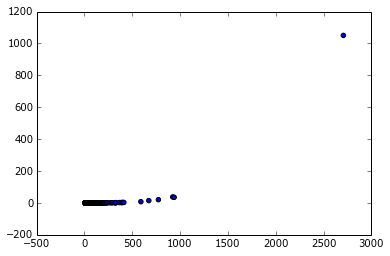

In [223]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(*zip(*plot))
plt.show()

График, построенный ниже, не учитывает самое большое количество запросов, чтобы он получился нагляднее

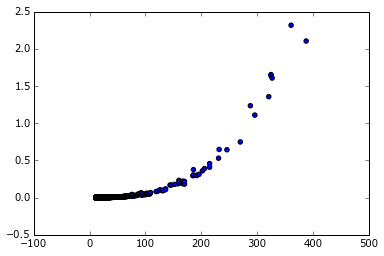

In [221]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(*zip(*plot))
plt.show()

По графику видно, что алгоритм имеет экспоненциальную сложность, что является показателем не оптимального алгоритма. Тем не менее, он выполняет свои функции на данной выборке за приемлимое время ~20min. Найдем максимальную длину цепочки периодичных событий: посмотрим на них.

In [225]:
print max([elem['chunk_length'] for elem in chunks])
for elem in chunks:
    if elem['chunk_length'] == 10:
        print elem

10
{'username': 'sevankoav', 'url': 'http://192.168.173.17/regenergovoda/appsrv/proxy.dll/Bin', 'chunk': [1457667857149L, 1457667858649L, 1457667860149L, 1457667861649L, 1457667863149L, 1457667864649L, 1457667866149L, 1457667867649L, 1457667869149L, 1457667870649L], 'chunk_length': 10}


Задание №5  
Поиск регулярных запросов (запросов выполняющихся периодически) по полю src_ip 

Делаем все тоже самое, что и для поля username

In [234]:
src_sorted_log = sorted(full_log[1:], key=lambda x: x['src_ip'])

In [235]:
src_time_list = list()
for src_ip, data in groupby(sorted_log, lambda x: x['src_ip']):
    new_data = list(data)
    sorted_data = sorted(new_data, key=lambda x: x['request_url'])
    for url, data in groupby(sorted_data, lambda x: x['request_url']):
        requests = list()
        list_of_data = list(data)
        sorted_data = sorted(list_of_data, key=lambda x: x['time'])
        for request in sorted_data:
            requests.append(int(float(request['time'])*1000))
        if len(requests) > 10:
            src_time_list.append({'src_ip': src_ip, 'url': url, 'count': len(requests), 'data': requests})

In [236]:
sorted_src_time_list = sorted(src_time_list, key=lambda x: x['count'])

In [237]:
src_chunks = list()

for index, elem in enumerate(sorted_src_time_list):
    time_start = time.time()
    new_time_list = elem['data']
    helpers = list()
    for i, core_event in enumerate(new_time_list):
        for j, next_core_event in enumerate(new_time_list[i+1:]):
            chunk = list()
            chunk.append(core_event)
            chunk.append(next_core_event)
            delta = next_core_event - core_event
            if delta <= 100:
                continue
            last_event = next_core_event
            for new_event in new_time_list[i+j+2:]:
                if new_event - last_event > delta:
                    if (chunk[-1], delta) in helpers:
                        break
                    if len(chunk) > 2:
                        helpers.append((chunk[-1], delta))
                        src_chunks.append({
                            'src_ip': elem['src_ip'],
                            'chunk': chunk,
                            'url': elem['url'],
                            'chunk_length': len(chunk),
                        })
                    break
                elif new_event - last_event < delta:
                    continue
                elif abs(new_event - last_event - delta) <= 100:
                    chunk.append(new_event)
                    last_event = new_event
                    continue

In [240]:
print max([elem['chunk_length'] for elem in src_chunks])
for elem in src_chunks:
    if elem['chunk_length'] >= 10:
        print elem

10
{'src_ip': '10.226.116.121', 'url': 'http://192.168.173.17/regenergovoda/appsrv/proxy.dll/Bin', 'chunk': [1457667857149L, 1457667858649L, 1457667860149L, 1457667861649L, 1457667863149L, 1457667864649L, 1457667866149L, 1457667867649L, 1457667869149L, 1457667870649L], 'chunk_length': 10}


Задание №6  
Рассматривая события сетевого трафика как символы неизвестного языка, найти 5 наиболее устойчивых N-грамм журнала событий (текста на неизвестном языке), (https://ru.wikipedia.org/wiki/N-грамм), где N=3-5. Тип символа задается парой username+request_url (в части имени сервера 2го уровня, то есть для username=ivanov и request_url="http://s01.do.update.2gis.com/ver3/ping" тип символа задан как "ivanov"+"2gis.com").

Сначала пройдемся по логу и создадим алфавит, исходя из правила, что тип символа задается парой username+request_url. (порт входит в части имени сервера 2го уровня) Посмотрим, сколько всего у нас букв в словаре. Закодируем каждую букву четырехзначным числом.

In [3]:
from urlparse import urlparse

alph = set()
for request in full_log[1:]:
    if not request['username'] == '-':
        if urlparse(request['request_url']).netloc == '':
            alph.add(request['username']+'.'.join(request['request_url'].split('.')[-2:]))
        else:
            alph.add(request['username']+'.'.join(urlparse(request['request_url']).netloc.split('.')[-2:]))

In [4]:
len(alph)

6733

In [5]:
encoded_alph = dict()
for i, elem in enumerate(alph):
    value = '%04d' % (i)
    encoded_alph[elem] = value

Составим текст на неизвестном языке с помощью нашего алфавита.

In [6]:
new_log = ''
for request in full_log[1:]:
    if not request['username'] == '-':
        if urlparse(request['request_url']).netloc == '':
            letter = request['username']+'.'.join(request['request_url'].split('.')[-2:])
        else:
            letter = request['username']+'.'.join(urlparse(request['request_url']).netloc.split('.')[-2:])
        new_log += encoded_alph[letter]

Создадим генератор, который будет итерироваться по строке с заданным окном и шагом.

In [7]:
def window(seq, win_size, step=1): 
    it = iter(seq)
    number_of_chunks = ((len(seq) - win_size) / step) + 1
    for i in range(0, number_of_chunks * step,step):
        yield seq[i:i + win_size]

Подсчитаем количество встреченых N-грамм, где N=3..5. Для этого будем изменять размер окна от 3 символов неизвестного алфавита до 5. Отсортируем по количеству и выведем 10 самых устойчивых N-грамм

In [20]:
reversed_encoded_alph = {v: k for k, v in encoded_alph.items()}

In [21]:
import operator

ngram_dict = dict()
for N in xrange(3, 6):
    for ngram in window(new_log, 4*N, 4):
        ngram_tuple = tuple([ngram[i:i+4] for i in range(0, len(ngram), 4)])
        if ngram_tuple not in ngram_dict:
            ngram_dict[ngram_tuple] = 0
        else:
            ngram_dict[ngram_tuple] += 1

In [22]:
sorted_ngram_dict = sorted(ngram_dict.items(), key=operator.itemgetter(1))
for elem, count in sorted_ngram_dict[-5:]:
    to_print = ', '.join([reversed_encoded_alph[item] for item in elem])
    print to_print, count

podkopaevataspletnik.ru, podkopaevataspletnik.ru, podkopaevataspletnik.ru, podkopaevataspletnik.ru 555
gamberovdvyandex.net:443, gamberovdvyandex.net:443, gamberovdvyandex.net:443, gamberovdvyandex.net:443, gamberovdvyandex.net:443 558
gamberovdvyandex.net:443, gamberovdvyandex.net:443, gamberovdvyandex.net:443, gamberovdvyandex.net:443 677
podkopaevataspletnik.ru, podkopaevataspletnik.ru, podkopaevataspletnik.ru 698
gamberovdvyandex.net:443, gamberovdvyandex.net:443, gamberovdvyandex.net:443 830


**Тестирование на проникновение**

Задание №1  
Вы получили доступ к компьютеру с операционной системой Windows с правами обычного пользователя. В процессе исследования реестра Вы обнаруживаете, что ключи HKEY_LOCAL_MACHINE\SOFTWARE\Policies\Microsoft\Windows\Installer\AlwaysInstallElevated и HKEY_CURRENT_USER\SOFTWARE\Policies\Microsoft\Windows\Installer\AlwaysInstallElevated имеют значение "1". Какие шаги Вы предпримите, для повышения привилегий в системе. 

Данные ключи в реестре указывают на то, что любой MSI-файл должен устанавливаться с повышенными привилегиями (NT AUTHORITY\SYSTEM). Можно создать специальный MSI-файл, который выполнит наши команды с повышенными привилегиями. После выполнения нашего кода можно вызвать прекращение установки, чтобы действия не были зарегистрированны в системе.

Для реализации этой атаки можно использовать Metasploit и его специальный модуль exploit/windows/local/always_install_elevated

Задание №2  
В процессе прослушивания сети в неразборчивом режиме, вы зафиксировали использование протоколов: ARP, CDP, RPC, DHCP, DTP, HSRP, DNS, SMB, STP, HTTP. Какие действия вы можете предпринять для развития атаки, основываясь на полученных данных? 

Проанализируем, какие протоколы мы зафиксировали и что мы можем предпринять

- ARP (Address Resolution Protocol) Определение соответствия IP и Ethernet адресов

Для данного протокола можно реализовать атаку вида ARP-spoofing, так как этот протокол не проверяет подлинность ARP-запросов и ARP-ответов. После того, как наш mac адрес попадет в ARP-таблицы, то в процессе общения двух узлов А и В все пакеты(кадры) будут проходить через наш узел.

- CDP (Cisco Discovery Protocol) — протокол второго уровня, разработанный компанией Cisco Systems, позволяющий обнаруживать подключённое сетевое оборудование Cisco (название/модель, версию IOS и IP-адреса, типы подключённых устройств, интерфейсы устройств

Данные по CDP передаются в незашифрованном виде. Название модели и версии IOS позволит определить наличие атак для конкретных моделей и версий. Возможно в версии 1 была какая-то уязвимость, а в версии 1.1 ее уже закрыли. И зная версию мы можем сразу реализовать\исключить атаку на устройства Cisco. Например: CVE-2012-2486, CVE-2012-3073, CVE-2012-3076. Удаленный пользователь может с помощью специально сформированного CDP компонента выполнить произвольный код на целевой системе. (актуально для Cisco TP RS версии 1.8 и ранее)

- RPC (Remote Procedure Call) — класс технологий, позволяющих компьютерным программам вызывать функции или процедуры в другом адресном пространстве (как правило, на удалённых компьютерах)

Для RPC имело место уязвимость CVE-2013-3175 и в зависимости от ОС и ее версии на клиенте, мы могли бы получить практически полный доступ к удаленному компьютеру. Для определения ОС можно использовать nmap

- DHCP (Dynamic Host Configuration Protocol) — сетевой протокол, позволяющий компьютерам автоматически получать IP-адрес и другие параметры, необходимые для работы в сети TCP/IP

Если мы определим, какой хост является DHCP сервером, то мы сможем определять, какие запросы клиентов отправлены для получения данных при регистрации в сети. В таком случае, если мы поднимем свой DHCP сервер, то мы можем отвечать на эти запросы, подменя DNS сервер. Таким образом и перенаправляя пользователей на другие сайты. Например, перенаправляя клиентов на свой yandex.ru и перехватывать данный авторизации, которые пользователь сам введет в формы, не подозревая о подмене.  

Кроме того мы можем осуществить атаку вида DHCP starvation, которая заставляет DHCP-сервер выдать все существующие на сервере адреса, что облегчит нам дальнейшее проникновение.

- DTP (Dynamic Trunking Protocol) — проприетарный сетевой протокол канального уровня, разработанный компанией Cisco для реализации транкинговой системы для связи в сети VLAN между двумя сетевыми коммутаторами и для реализации инкапсуляции

Можно осуществить атака типа VLAN hooping. Если атакующее устройство будет вести себя как порт в режиме desirable оно согласует на себя trunk-порт и получит доступ к трафику всех VLAN’ов, которыми оперирует коммутатор.

- HSRP (Hot Standby Redundancy Protocol) — протокол, разработанный компанией Cisco Systems, задача которого состоим в том, чтобы добиться максимальной доступности и отказоустойчивости первого хопа от отправителя ("маршрут по умолчанию")

В некоторых версиях Cisco IOS (например, в 12.1) возможно сконструировать специальный HSRP трафик (отправлять запросы на 1985 порт UDP пакетами со случайными размерами), который создаст состояние петли, в результате маршрутизатор зависнет.
Версию мы сможем узнать с помощью CDP протокола.

- DNS (Domain Name System) — компьютерная распределённая система для получения информации о доменах

Уязвимости, связанные с DNS были описаны в разделе про DHCP. Кроме того: Amplification attack (атака с усилением) — направлена на перегрузку исходящего канала DNS-сервера. Она начинаются с отправки большого количества DNS-запросов, специально подобранных таким образом, чтобы получить очень большой ответ, размер которого может до 70 раз превышать размер запроса, что приведет к перегрузке исходящего канала DNS-сервера и в конечном счете к отказу в обслуживании (DoS);

- SMB (Server Message Block) — сетевой протокол прикладного уровня для удалённого доступа к файлам, принтерам и другим сетевым ресурсам, а также для межпроцессного взаимодействия

Известная такая уязвимость, как Redirect to SMB. (актуальна для Windows и программ, использующие Windows API) Если мы отправим клиенту адресс file://1.1.1.1/, то когда пользователь его откроет в браузере IE, операционная система попробует авторизоваться на SMB-сервере с IP-адресом 1.1.1.1. Кроме того, прослушивая трафик SMB мы можем выловить Session ID и с помощью него получить доступ к cmd жертвы. Также можно упомянуть SMBRelay.

- STP (Spanning Tree Protocol) — канальный протокол, основной задачей которого является устранение петель в топологии произвольной сети Ethernet, в которой есть один или более сетевых мостов, связанных избыточными соединениями

Посколько в STP нет механизмов аутентификации, то мы можем создать BPDU фреймы с несуществующим корневым мостом. Используя минимальное значение max-age, мы спровоцируем повторный выбор корневого моста.

- HTTP (HyperText Transfer Protocol) — протокол прикладного уровня передачи данных (изначально — в виде гипертекстовых документов в формате HTML, в настоящий момент используется для передачи произвольных данных)

Что касается HTTP, то здесь очень много различных уязвимостей, которые можно было бы использовать. Для начала, получая весь трафик, который идет при авторизации на различных сайтах без шифрования (чистый http), мы сможем поймать как сами логины\пароли, так и сессионные куки, которые сайты выдают пользователям. И другие уязвимости прикладного уровня: Инъекции (SQL, LDAP), Cross Site Scripting (XSS), Cross Site Request Forgery (CSRF) 